# Bilevel Differential grasp planner

## Minimal Distance between two convex hulls
Two random point clouds are generated and their convex hulls are computed with scipy.spatial.ConvexHull. The minimal distance between them are optimized by QP solver in CVXPY

In [118]:
import numpy as np
import cvxpy as cp
from pypoman import compute_polytope_vertices, compute_polytope_halfspaces 
import plotly.graph_objects as go
import torch
import torch.nn as nn
from pprint import pprint
pi = torch.acos(torch.zeros(1)).item() *2


In [51]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [52]:
points1 = np.random.rand(30, 3)
points2 = np.random.rand(30, 3) + 3

hull1 = ConvexHull(points1)
hull2 = ConvexHull(points2)
inpoint1 = points1[~hull1.vertices, :][0, :]
inpoint2 = points2[~hull2.vertices, :][0, :]


In [96]:
def get_feasible_region(hull):
    inpoint = hull.points[~hull.vertices, :][0, :]   
    negative = hull.equations[:, :-1] @ inpoint + hull.equations[:, -1]
    return negative

print(get_feasible_region(hull1))

[-0.08338136 -0.04645507 -0.00812397 -0.74957559 -0.49620081 -0.28982002
 -0.27469716 -0.73205402 -0.11637405 -0.39917773 -0.49439968 -0.43363998
  0.          0.          0.         -0.25465007 -0.25769105 -0.47322206
 -0.581712   -0.73186528 -0.66294413 -0.77049322 -0.77709344 -0.74094502
 -0.25558218 -0.30525826 -0.33415133 -0.41230018 -0.45393514 -0.3053008
 -0.2776234  -0.27637871 -0.45111984 -0.68888174 -0.5741057  -0.60444528]


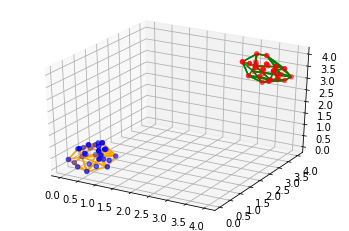

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(points1[:,0], points1[:,1], points1[:,2], c='blue')
for simplex1 in hull1.simplices:
    ax.plot3D(points1[simplex1, 0], points1[simplex1, 1], points1[simplex1, 2],  'orange')

ax.scatter3D(points2[:,0], points2[:,1], points2[:,2], c='red')
for simplex2 in hull2.simplices:
    ax.plot3D(points2[simplex2, 0], points2[simplex2, 1], points2[simplex2, 2] ,'green')

In [55]:
v1 = points1[hull1.vertices]
v2 = points2[hull2.vertices]

In [56]:
A1, b1 = compute_polytope_halfspaces(v1)
A2, b2 = compute_polytope_halfspaces(v2)

In [57]:
A1, b1 = hull1.equations[:, :-1], -hull1.equations[:, -1]
A2, b2 = hull2.equations[:, :-1], -hull2.equations[:, -1]

In [58]:
x1 = cp.Variable(3)
x2 = cp.Variable(3)

objective = cp.Minimize(cp.sum_squares(x1 - x2))
constraints = [A1 @ x1 <= b1, A2 @ x2 <= b2]
prob = cp.Problem(objective, constraints)
print("optimal value = ", prob.solve())
print("optimal x1 = ", x1.value)
print('optimal x2 = ', x2.value)
optimal_dots = np.array([x1.value, x2.value])

optimal value =  18.61044407044256
optimal x1 =  [0.64550624 0.68846671 0.97735769]
optimal x2 =  [3.24032534 3.22060849 3.31522336]


In [98]:
simplex1 = hull1.simplices
simplex2 = hull2.simplices
fig = go.Figure()
for i in range(simplex1.shape[0]):
    if i == 0:
        fig.add_trace(go.Mesh3d(x=points1[simplex1[i], 0],
                                y=points1[simplex1[i], 1],
                                z=points1[simplex1[i], 2],
                                color='lightpink',
                                opacity=0.5,
                                legendgroup='Convex Hull1',
                                name='Convex Hull1',
                                showlegend=True))
    else:
        fig.add_trace(go.Mesh3d(x=points1[simplex1[i], 0],
                                y=points1[simplex1[i], 1],
                                z=points1[simplex1[i], 2],
                                color='lightpink',
                                opacity=0.5,
                                legendgroup='Convex Hull1',
                                name='Convex Hull1',
                                showlegend=False))
    
for i in range(simplex2.shape[0]):
    if i == 0:
        fig.add_trace(go.Mesh3d(x=points2[simplex2[i], 0],
                                y=points2[simplex2[i], 1],
                                z=points2[simplex2[i], 2],
                                color='lightblue',
                                opacity=0.5,
                                legendgroup='Convex Hull2',
                                name='Convex Hull2',
                                showlegend=True))
    else:
        fig.add_trace(go.Mesh3d(x=points2[simplex2[i], 0],
                                y=points2[simplex2[i], 1],
                                z=points2[simplex2[i], 2],
                                color='lightblue',
                                opacity=0.5,
                                legendgroup='Convex Hull2',
                                name='Convex Hull2',
                                showlegend=False))

fig.add_trace(go.Scatter3d(x=optimal_dots[:, 0],
                           y=optimal_dots[:, 1],
                           z=optimal_dots[:, 2],
                           marker=dict(size=4,
                                       color='tomato',
                                       symbol='diamond'),
                           line=dict(color='tomato',
                                     width=4),
                           legendgroup="Smallest Distance",
                           name="Smallest Distance"))
fig.update_layout(scene_camera=dict(eye=dict(x=1.2, y=-1.6, z=1.0)), 
                  margin=dict(t=0, r=10, l=10, b=10),
                  legend=dict(x=0.6, y=1))
fig.show()

In [60]:
import plotly

# plotly.io.write_image(fig, r'../bilevel_figs/dist_of_convexhulls.png', scale = 10)

## Tunnelling Free Opimization

In [61]:
from LBFGS import LBFGS, FullBatchLBFGS

In [62]:
import torch 
from torch.optim import Optimizer

### Initializing a cube as a simulated hand and a target object

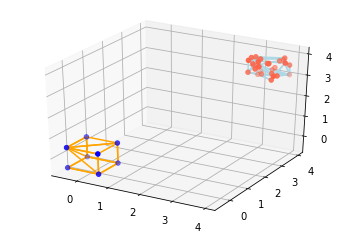

In [272]:
cube = np.array([[-0.5, -0.5, -0.5],
                 [-0.5 , 0.5 ,-0.5],
                 [ 0.5 ,-0.5 ,-0.5],
                 [ 0.5 , 0.5 ,-0.5],
                 [-0.5 , 0.5 , 0.5],
                 [ 0.5 ,-0.5 , 0.5],
                 [-0.5 ,-0.5 , 0.5],
                 [ 0.5 , 0.5 , 0.5]])

center = np.zeros((8, 3))
def control_cube(start:np.array, control_dict:dict=dict(d=0, alpha=0, beta=0, gamma=0))->np.array:
    end = start + control_dict[d]
    return end
hull = ConvexHull(cube)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(cube[:,0], cube[:,1], cube[:,2], c='blue')
for simplex1 in hull.simplices:
    ax.plot3D(cube[simplex1, 0], cube[simplex1, 1], cube[simplex1, 2],  'orange')
    
points2 = np.random.rand(30, 3) + 3
hull2 = ConvexHull(points2)
ax.scatter3D(points2[:, 0], points2[:, 1], points2[:, 2], c='tomato')
for simplex2 in hull2.simplices:
    ax.plot3D(points2[simplex2, 0], points2[simplex2, 1], points2[simplex2, 2],  'lightblue')
    

In [273]:
# distance between two convex hulls
def distance_between_convex_hulls(hull1, hull2):
    A1, b1 = hull1.equations[:, :-1], -hull1.equations[:, -1]
    A2, b2 = hull2.equations[:, :-1], -hull2.equations[:, -1]
    
    x1 = cp.Variable(3)
    x2 = cp.Variable(3)

    objective = cp.Minimize(cp.sum_squares(x1 - x2))
    constraints = [A1 @ x1 <= b1, A2 @ x2 <= b2]
    prob = cp.Problem(objective, constraints)
    min_dist = prob.solve()
    return min_dist, x1.value, x2.value


In [274]:
# initial guess of parameters
beta, phi = torch.Tensor([pi/4]), torch.Tensor([pi/4])


d = distance_between_convex_hulls(hull, hull2)
print('d = :', d)
d = torch.Tensor([d[0]/5]).requires_grad_(True)
theta = torch.Tensor([0.5, 0.5, 0.5]).requires_grad_(True)

# define objective function
def obj(beta, phi, theta, d, ch0, ch2):
    # unit vector expressed in sphere coordinates
    tol = 1e-4
    if phi - pi/2 <= tol:
        phi = torch.Tensor([0])
        beta = torch.Tensor([0])
    n = torch.Tensor([torch.cos(beta) * torch.cos(phi), torch.sin(beta) * torch.cos(phi), torch.sin(phi)]).reshape(1, 3).requires_grad_(True)
    
    # partial derivative of n with respect to beta
    pn_pbeta = torch.Tensor([-torch.sin(beta) * torch.cos(phi), torch.cos(beta) * torch.cos(phi), torch.sin(phi)]).reshape(3, 1)
    # partial derivative of n with respect to phi
    pn_pphi = torch.Tensor([-torch.cos(beta) * torch.sin(phi), -torch.sin(beta) * torch.sin(phi), torch.cos(phi)]).reshape(3, 1)
    # all the points contained in or on convex hulls
    points0 = torch.Tensor(ch0.points)
#     ch1 = ConvexHull(points0 + theta)
#     points1 = torch.Tensor(ch1.points)
    points1 = points0 + theta
    points2 = torch.Tensor(ch2.points)
    # vertices of two convex hulls
#     v1 = points1[ch1.vertices, :].T
    v1 = points1[ch0.vertices, :].T
    v2 = points2[ch2.vertices, :].T
    # value of objective function
    objective = torch.sum(torch.log(torch.matmul(n, v2) - d * torch.ones(1, v2.shape[1]))) + torch.sum(torch.log(d * torch.ones(1, v1.shape[1]) - torch.matmul(n, v1)))
    objective *= -1
    # The chain rule. Partial derivativ e of O with respect to n
    po_pn = torch.sum(v2/(n.mm(v2) - d), dim=1) - torch.sum(v1/(d - n.mm(v1)), dim=1)
    po_pn = po_pn.reshape(1, 3)
    # Partial derivative of O with respect to beta and phi
    po_pbeta = po_pn.mm(pn_pbeta)
    po_pphi = po_pn.mm(pn_pphi)
    # Partial derivative of O with respect to d
    po_pd = -torch.sum(1/(n.mm(v2) - d)) + torch.sum(1/(d - n.mm(v1)))
    # partial derivative of O with respect to v

    po_pv = n * torch.sum(1 / (n.mm(v2) - d)) - n * torch.sum(1 / (d - n.mm(v1)))
    po_ptheta = po_pv
    return {'objective': objective, 'po_pbeta': po_pbeta, 'po_pphi': po_pphi, 'po_pd': po_pd, "po_ptheta": po_ptheta, "n": n, "po_pn": po_pn, "beta": beta, 'phi': phi, 'theta': theta}

d = : (21.707712892311633, array([0.5, 0.5, 0.5]), array([3.11812309, 3.03215483, 3.40539779]))


In [275]:
result = obj(beta, phi, theta, d, hull, hull2)
result['objective'].backward()
print('torch: d.grad = ', d.grad) 
print('torch: theta.grad = ', theta.grad)
print('torch: n.grad = ', result['n'].grad)
pprint(result)

torch: d.grad =  tensor([-25.4973])
torch: theta.grad =  tensor([2.1184, 0.0000, 0.0000])
torch: n.grad =  tensor([[85.6976, 83.4268, 84.4531]])
{'beta': tensor([0.]),
 'n': tensor([[1., 0., 0.]], requires_grad=True),
 'objective': tensor(nan, grad_fn=<MulBackward0>),
 'phi': tensor([0.]),
 'po_pbeta': tensor([[-83.4268]], grad_fn=<MmBackward>),
 'po_pd': tensor(25.4973, grad_fn=<AddBackward0>),
 'po_pn': tensor([[-85.6976, -83.4268, -84.4531]], grad_fn=<ViewBackward>),
 'po_pphi': tensor([[-84.4531]], grad_fn=<MmBackward>),
 'po_ptheta': tensor([[-25.4973,  -0.0000,  -0.0000]], grad_fn=<SubBackward0>),
 'theta': tensor([0.5000, 0.5000, 0.5000], requires_grad=True)}


In [276]:
print(torch.isnan(result['objective']))

tensor(True)


### Line Search

In [277]:
# initial guess of parameters
beta, phi = torch.Tensor([0]), torch.Tensor([0])


d = distance_between_convex_hulls(hull, hull2)
print('d = :', d)
d = torch.Tensor([d[0]/10]).requires_grad_(True)
theta = torch.Tensor([0.1, 0.1, 0.1]).requires_grad_(True)

gamma = 1
tol = 1e-10
max_iters = 200
scale = 0.7
c1 = 0.7
result = obj(beta, phi, theta, d, hull, hull2)

for i in range(max_iters):
    old_obj = result['objective']
    print(old_obj, end=' ')
    s = 10
    beta_temp, phi_temp, theta_temp, d_temp = torch.remainder(beta - s * result['po_pbeta'], 2 * pi), \
                                              torch.remainder(phi   - s * result['po_pphi'], 2 * pi), \
                                              theta - s * result['po_ptheta'], \
                                              d     - s * result['po_pd'] 
    result_temp = obj(beta_temp, phi_temp, theta_temp, d_temp, hull, hull2)
    print('finding feasible step size...')
    # keep objective value from Nan
    while torch.isnan(result_temp['objective']):
        s *= scale
        beta_temp, phi_temp, theta_temp, d_temp = torch.remainder(beta - s * result['po_pbeta'], 2 * pi), \
                                              torch.remainder(phi   - s * result['po_pphi'], 2 * pi), \
                                              theta - s * result['po_ptheta'], \
                                              d     - s * result['po_pd'] 
        result_temp = obj(beta_temp, phi_temp, theta_temp, d_temp, hull, hull2)
    print('s1 = ',s)
    print('finding proper step size to minize the objective function...')   
    
    # Armijo Condition
    while result_temp['objective'] > old_obj - c1 * s * torch.sum(torch.Tensor([result['po_pbeta'], 
                                                                                result['po_pphi'], 
                                                                                torch.sum(result['po_ptheta']), 
                                                                                result['po_pd']])):
        tmp_s = s
        s *= scale
        if torch.abs(torch.Tensor([s - tmp_s])) <= tol:
            break
                                                                  
    print('s2 = ',s)
    beta, phi, theta, d = torch.remainder(beta - s * result['po_pbeta'], 2 * pi), \
                          torch.remainder(phi   - s * result['po_pphi'], 2 * pi), \
                          theta - s * result['po_ptheta'], \
                          d     - s * result['po_pd'] 
    
    result = obj(beta, phi, theta, d, hull, hull2)
    if torch.abs(result['objective'] - old_obj) < tol:
        print("Converged")
        break
#     beta, phi = torch.Tensor([0]), torch.Tensor([0])
    print('Next Round')
    

d = : (21.707712892311633, array([0.5, 0.5, 0.5]), array([3.11812309, 3.03215483, 3.40539779]))
tensor(-9.0390, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0390, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0390, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0390, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0390, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step 

s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0389, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0389, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0389, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0389, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0389, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.0678223

s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0389, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0389, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0389, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0389, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0389, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.0678223

s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0388, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0388, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0388, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0388, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0388, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514

s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round
tensor(-9.0388, grad_fn=<MulBackward0>) finding feasible step size...
s1 =  0.06782230728489994
finding proper step size to minize the objective function...
s2 =  2.0500514515695399e-10
Next Round


In [278]:
pprint(result)

{'beta': tensor([[6.2832]], grad_fn=<RemainderBackward0>),
 'n': tensor([[ 1.0000e+00, -2.0116e-06, -2.1090e-06]], requires_grad=True),
 'objective': tensor(-9.0388, grad_fn=<MulBackward0>),
 'phi': tensor([[6.2832]], grad_fn=<RemainderBackward0>),
 'po_pbeta': tensor([[49.0614]], grad_fn=<MmBackward>),
 'po_pd': tensor(-10.3060, grad_fn=<AddBackward0>),
 'po_pn': tensor([[47.3722, 49.0614, 51.4387]], grad_fn=<ViewBackward>),
 'po_pphi': tensor([[51.4388]], grad_fn=<MmBackward>),
 'po_ptheta': tensor([[ 1.0306e+01, -2.0731e-05, -2.1736e-05]], grad_fn=<SubBackward0>),
 'theta': tensor([[0.1000, 0.1000, 0.1000]], grad_fn=<SubBackward0>)}


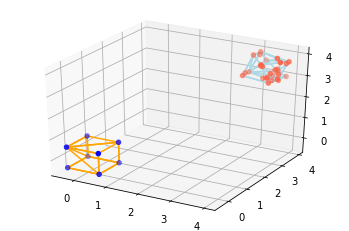

In [250]:
cube = np.array([[-0.5, -0.5, -0.5],
                 [-0.5 , 0.5 ,-0.5],
                 [ 0.5 ,-0.5 ,-0.5],
                 [ 0.5 , 0.5 ,-0.5],
                 [-0.5 , 0.5 , 0.5],
                 [ 0.5 ,-0.5 , 0.5],
                 [-0.5 ,-0.5 , 0.5],
                 [ 0.5 , 0.5 , 0.5]])

cube += theta.detach().numpy()

hull = ConvexHull(cube)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(cube[:,0], cube[:,1], cube[:,2], c='blue')
for simplex1 in hull.simplices:
    ax.plot3D(cube[simplex1, 0], cube[simplex1, 1], cube[simplex1, 2],  'orange')
    
points2 = np.random.rand(30, 3) + 3
hull2 = ConvexHull(points2)
ax.scatter3D(points2[:, 0], points2[:, 1], points2[:, 2], c='tomato')
for simplex2 in hull2.simplices:
    ax.plot3D(points2[simplex2, 0], points2[simplex2, 1], points2[simplex2, 2],  'lightblue')
    

In [251]:
theta

tensor([[0.1000, 0.1000, 0.1000]], grad_fn=<SubBackward0>)